<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/load_and_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pronto owlready2 \
&& wget -O doid.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/EfUC_RdrfZdOsOrtmNATjuoBPDaIkSTUMyxJXyO2KKC6yw?download=1 \
&& wget -O ncit.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/ETmaJIC0fAlItdsp8WQxS_wBzKN_6x08EZrtsOxVnbzvSg?download=1

In [2]:
import pronto
import owlready2
import editdistance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [3]:
ncit = pronto.Ontology("ncit.obo")
doid = pronto.Ontology("doid.obo")

# Extract equivalences

In [24]:
def correct_id(id, correction={"NCI:" : "NCIT:"}):
  before, after = list(correction.items())[0]
  return id.replace(before, after)

def get_entity_equivalences(source_onto, target_onto_code="NCI:"):
  all_equivalences = {}
  for term in source_onto.terms():
    xrefs = term.xrefs
    ids = [str(ref).split("'")[1] for ref in xrefs if target_onto_code in str(ref)]
    if len(ids) == 1:
      all_equivalences[correct_id(term.id)] = correct_id(ids[0])
  return all_equivalences

In [20]:
def write_mappings(mappings, filepath):
  with open(filepath, "w") as f:
    for source_id, target_id in mappings.items():
      f.write(f"{source_id},{target_id}\n")

In [25]:
all_equivalences = get_entity_equivalences(doid)
print("Total equivalences: ", len(all_equivalences))

Total equivalences:  4331


In [26]:
write_mappings(all_equivalences, "equiv_doid2ncit.csv")
write_mappings({v:k for (k,v) in all_equivalences.items()}, "equiv_ncit2doid.csv")

# Derive subsumptions

In [29]:
def get_subsumptions_from_equivalences(equivalences, source_onto, target_onto, negative=False, reverse=False):
  np.random.seed(3)
  source_ids = list(equivalences.keys())
  target_ids = list(equivalences.values())
  subsumptions = {}

  source_parent_counts = []
  target_parent_counts = []

  for source_id, target_id in tqdm(equivalences.items()):
    if source_id in source_onto.terms():
      source_entity = source_onto.get_term(source_id)
      source_parents = set(source_entity.superclasses(distance=1, with_self=False))
      source_parent_counts.append(len(source_parents))

      if target_id in target_onto.terms():
        target_entity = target_onto.get_term(target_id)
        target_parents = set(target_entity.superclasses(distance=1, with_self=False))
        target_parent_counts.append(len(target_parents))

        # Only keep mappings with single parents
        if len(target_parents) == 1 and len(source_parents) == 1:

          if not negative:
            if reverse:
              subsumptions[target_id] = source_parents.pop().id
            else:
              subsumptions[source_id] = target_parents.pop().id

          else:
            if reverse:
              source_parent_id = source_parents.pop().id
              neg_sub = source_ids[np.random.randint(0, len(source_ids))]
              while (neg_sub == source_id) or (neg_sub == source_parent_id):
                neg_sub = source_ids[np.random.randint(0, len(source_ids))]
              subsumptions[target_id] = neg_sub
            else:
              target_parent_id = target_parents.pop().id
              neg_sub = target_ids[np.random.randint(0, len(target_ids))]
              while (neg_sub == target_id) or (neg_sub == target_parent_id):
                neg_sub = target_ids[np.random.randint(0, len(target_ids))]
              subsumptions[source_id] = neg_sub

  print()
  print("Source parent counts: ", Counter(source_parent_counts))
  print("Target parent counts: ", Counter(target_parent_counts))
  return subsumptions

In [33]:
subs_doid2ncit = get_subsumptions_from_equivalences(all_equivalences, doid, ncit)
print("Total subsumptions (DOID to NCIT): ", len(subs_doid2ncit))

100%|██████████| 4331/4331 [00:00<00:00, 9373.07it/s]


Source parent counts:  Counter({1: 3242, 2: 983, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Target parent counts:  Counter({1: 2209, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total subsumptions (DOID to NCIT):  1883


In [32]:
random_neg_doid2ncit = get_subsumptions_from_equivalences(all_equivalences, doid, ncit, negative=True)
print("Total (random) negative subsumptions (DOID to NCIT): ", len(random_neg_doid2ncit))

100%|██████████| 4331/4331 [00:00<00:00, 9018.70it/s]


Source parent counts:  Counter({1: 3242, 2: 983, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Target parent counts:  Counter({1: 2209, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total (random) negative subsumptions (DOID to NCIT):  1883


In [34]:
subs_ncit2doid = get_subsumptions_from_equivalences(all_equivalences, doid, ncit, reverse=True)
print("Total subsumptions (NCIT to DOID): ", len(subs_ncit2doid))

100%|██████████| 4331/4331 [00:00<00:00, 9121.88it/s]


Source parent counts:  Counter({1: 3242, 2: 983, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Target parent counts:  Counter({1: 2209, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total subsumptions (NCIT to DOID):  1873


In [35]:
random_neg_ncit2doid = get_subsumptions_from_equivalences(all_equivalences, doid, ncit, negative=True, reverse=True)
print("Total (random) negative subsumptions (NCIT to DOID): ", len(random_neg_ncit2doid))

100%|██████████| 4331/4331 [00:00<00:00, 8214.67it/s]


Source parent counts:  Counter({1: 3242, 2: 983, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Target parent counts:  Counter({1: 2209, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total (random) negative subsumptions (NCIT to DOID):  1873


In [36]:
write_mappings(subs_doid2ncit, "subs_doid2ncit.csv")
write_mappings(random_neg_doid2ncit, "random_neg_doid2ncit.csv")
write_mappings(subs_ncit2doid, "subs_ncit2doid.csv")
write_mappings(random_neg_ncit2doid, "random_neg_ncit2doid.csv")

# String difference

## Equivalences

In [ ]:
str_equivalences = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in all_equivalences.items() if source in doid.terms() and target in ncit.terms()}

distances = np.array([editdistance.eval(source, target) for (source, target) in str_equivalences.items()])
lengths = np.array([max(len(source), len(target)) for (source, target) in str_equivalences.items()])
normalised = np.round(distances / lengths, decimals=2)

dist_distribution = Counter(distances)
norm_distribution = Counter(normalised)

Distances: [(0, 2384), (1, 95), (2, 126), (3, 50), (4, 114), (5, 84), (6, 66), (7, 93), (8, 139), (9, 72), (10, 77), (11, 69), (12, 43), (13, 59), (14, 64), (15, 70), (16, 75), (17, 52), (18, 82), (19, 40), (20, 51), (21, 37), (22, 33), (23, 42), (24, 31), (25, 34), (26, 28), (27, 20), (28, 11), (29, 22), (30, 7), (31, 12), (32, 10), (33, 19), (34, 19), (35, 14), (36, 7), (37, 9), (38, 4), (39, 5), (40, 9), (41, 2), (42, 7), (43, 3), (44, 5), (45, 4), (46, 5), (47, 3), (48, 2), (49, 1), (50, 6), (51, 1), (52, 1), (53, 2), (54, 1), (55, 4), (58, 2), (59, 1), (82, 1), (95, 1)]
Median: 0.0, Mean: 6.25, STD: 10.02


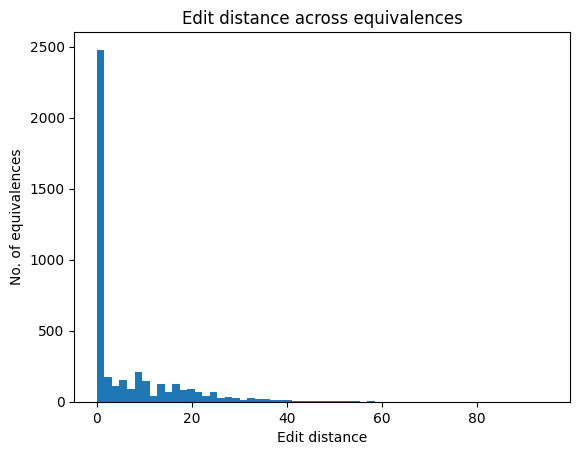

In [ ]:
plt.hist(distances, bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences")
print("Distances:", sorted(dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(distances)}, Mean: {np.mean(distances):.2f}, STD: {np.std(distances):.2f}")

Text(0.5, 1.0, 'Edit distance across equivalences (0s excluded)')

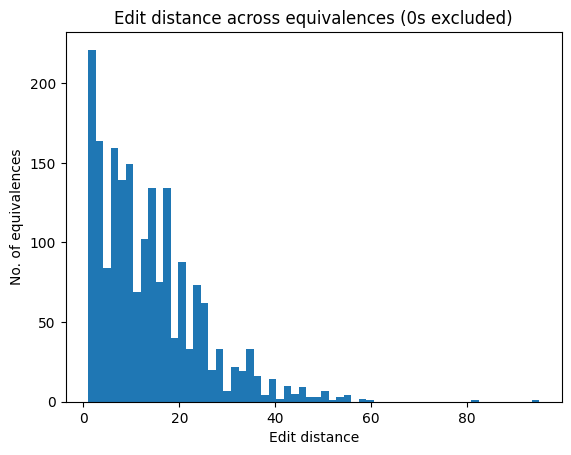

In [ ]:
plt.hist(distances[distances != 0], bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences (0s excluded)")

Normalised: [(0.0, 2384), (0.01, 1), (0.02, 11), (0.03, 31), (0.04, 23), (0.05, 21), (0.06, 19), (0.07, 31), (0.08, 24), (0.09, 20), (0.1, 21), (0.11, 17), (0.12, 28), (0.13, 9), (0.14, 32), (0.15, 24), (0.16, 28), (0.17, 33), (0.18, 20), (0.19, 27), (0.2, 24), (0.21, 31), (0.22, 20), (0.23, 30), (0.24, 36), (0.25, 28), (0.26, 17), (0.27, 38), (0.28, 27), (0.29, 35), (0.3, 22), (0.31, 32), (0.32, 36), (0.33, 44), (0.34, 9), (0.35, 28), (0.36, 28), (0.37, 15), (0.38, 39), (0.39, 17), (0.4, 26), (0.41, 22), (0.42, 25), (0.43, 29), (0.44, 25), (0.45, 14), (0.46, 19), (0.47, 27), (0.48, 24), (0.49, 8), (0.5, 31), (0.51, 10), (0.52, 29), (0.53, 22), (0.54, 14), (0.55, 20), (0.56, 25), (0.57, 27), (0.58, 22), (0.59, 22), (0.6, 20), (0.61, 17), (0.62, 26), (0.63, 14), (0.64, 17), (0.65, 14), (0.66, 13), (0.67, 17), (0.68, 23), (0.69, 12), (0.7, 16), (0.71, 14), (0.72, 15), (0.73, 14), (0.74, 14), (0.75, 18), (0.76, 15), (0.77, 22), (0.78, 12), (0.79, 32), (0.8, 19), (0.81, 22), (0.82, 18), (0

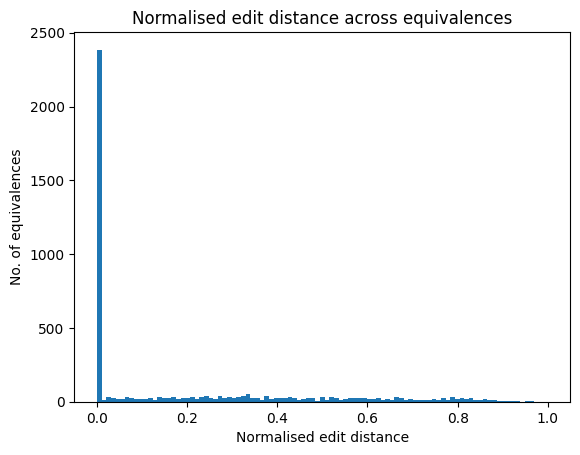

In [ ]:
plt.hist(normalised, bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences")
print("Normalised:", sorted(norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(normalised)}, Mean: {np.mean(normalised):.2f}, STD: {np.std(normalised):.2f}")

Text(0.5, 1.0, 'Normalised edit distance across equivalences (0s excluded)')

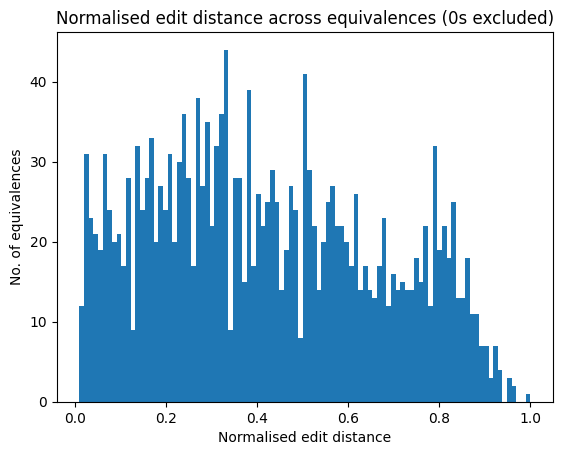

In [ ]:
plt.hist(normalised[normalised != 0], bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences (0s excluded)")

{'whiskers': [<matplotlib.lines.Line2D at 0x7850932bdd80>,
 'caps': [<matplotlib.lines.Line2D at 0x7850932bd270>,
 'boxes': [<matplotlib.lines.Line2D at 0x7850932be230>],
 'medians': [<matplotlib.lines.Line2D at 0x785094fc8e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x785094fc8a60>],
 'means': []}

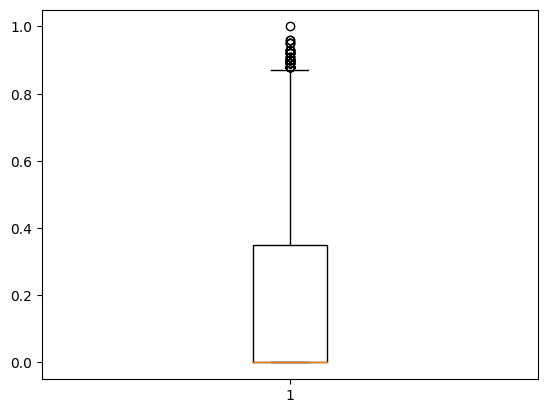

In [ ]:
plt.boxplot(normalised)

In [ ]:
print("Equivalences with distinct terms:\n")

count = 0
for (source, target) in str_equivalences.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    count += 1
    if count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{count} out of {len(str_equivalences)} ({(100 * count/len(str_equivalences)):.1f}%) are distinct")

Equivalences with distinct terms:

ovarian sex cord-stromal benign neoplasm -> benign ovarian sex cord-stromal tumor
jejunal cancer -> malignant jejunal neoplasm
acute myeloid leukemia with t(1;22)(p13;q13) -> acute myeloid leukemia (megakaryoblastic) with t(1;22)(p13.3;q13.1); rbm15-mkl1
46,xy sex reversal -> 46,xy gonadal dysgenesis
social phobia -> social anxiety disorder
acquired hyperkeratosis -> acquired keratoderma
pfeiffer syndrome -> type v acrocephalosyndactyly
giant cell reparative granuloma -> central giant cell granuloma
glycogen storage disease v -> glycogen storage disease type v
pancreatic signet ring cell adenocarcinoma -> pancreatic signet ring cell carcinoma
weissenbacher-zweymuller syndrome -> pierre robin syndrome
brain stem astrocytic neoplasm -> brain stem astrocytoma
water-clear cell adenoma -> parathyroid gland water-clear cell adenoma
childhood parosteal osteogenic sarcoma -> childhood parosteal osteosarcoma
mediastinal melanocytic neurilemmoma -> mediastinal 

## Subsumptions

In [ ]:
str_subsumptions = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in doid_to_ncit_subs.items() if source in doid.terms() and target in ncit.terms()}

sub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_subsumptions.items()])
sub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_subsumptions.items()])
sub_normalised = np.round(sub_distances / sub_lengths, decimals=2)

sub_dist_distribution = Counter(sub_distances)
sub_norm_distribution = Counter(sub_normalised)

Distances: [(0, 11), (1, 1), (2, 5), (3, 5), (4, 14), (5, 30), (6, 54), (7, 60), (8, 97), (9, 99), (10, 104), (11, 102), (12, 101), (13, 87), (14, 93), (15, 76), (16, 80), (17, 76), (18, 60), (19, 55), (20, 74), (21, 52), (22, 55), (23, 66), (24, 58), (25, 46), (26, 42), (27, 28), (28, 21), (29, 28), (30, 31), (31, 21), (32, 24), (33, 22), (34, 11), (35, 9), (36, 11), (37, 8), (38, 10), (39, 8), (40, 8), (41, 3), (42, 7), (43, 1), (44, 7), (45, 7), (46, 3), (47, 4), (48, 4), (49, 1), (52, 1), (53, 1), (54, 1)]
Median: 16.0, Mean: 17.34, STD: 9.08


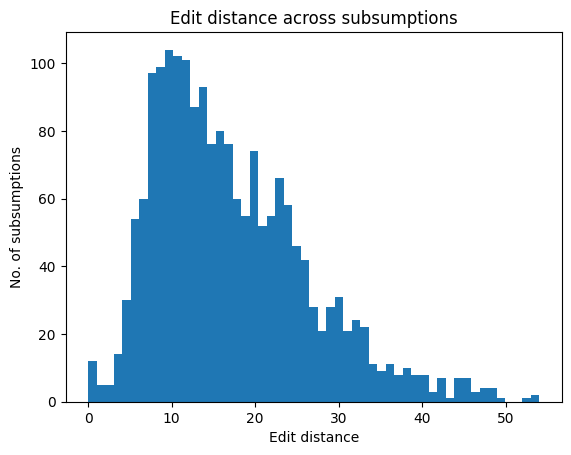

In [ ]:
plt.hist(sub_distances, bins=len(sub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Edit distance across subsumptions")
print("Distances:", sorted(sub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(sub_distances)}, Mean: {np.mean(sub_distances):.2f}, STD: {np.std(sub_distances):.2f}")

Normalised: [(0.0, 11), (0.07, 1), (0.08, 1), (0.09, 1), (0.11, 2), (0.14, 2), (0.15, 2), (0.16, 1), (0.17, 6), (0.18, 4), (0.19, 4), (0.2, 3), (0.21, 6), (0.22, 5), (0.23, 9), (0.24, 7), (0.25, 11), (0.26, 9), (0.27, 8), (0.28, 8), (0.29, 13), (0.3, 14), (0.31, 22), (0.32, 13), (0.33, 25), (0.34, 10), (0.35, 27), (0.36, 25), (0.37, 14), (0.38, 24), (0.39, 26), (0.4, 25), (0.41, 21), (0.42, 28), (0.43, 33), (0.44, 31), (0.45, 35), (0.46, 20), (0.47, 27), (0.48, 25), (0.49, 6), (0.5, 67), (0.51, 7), (0.52, 31), (0.53, 34), (0.54, 21), (0.55, 34), (0.56, 48), (0.57, 28), (0.58, 22), (0.59, 24), (0.6, 23), (0.61, 22), (0.62, 28), (0.63, 13), (0.64, 21), (0.65, 26), (0.66, 13), (0.67, 31), (0.68, 26), (0.69, 17), (0.7, 33), (0.71, 34), (0.72, 14), (0.73, 22), (0.74, 33), (0.75, 34), (0.76, 26), (0.77, 29), (0.78, 34), (0.79, 83), (0.8, 41), (0.81, 51), (0.82, 43), (0.83, 48), (0.84, 47), (0.85, 37), (0.86, 41), (0.87, 19), (0.88, 28), (0.89, 27), (0.9, 11), (0.91, 7), (0.92, 8), (0.93, 11)

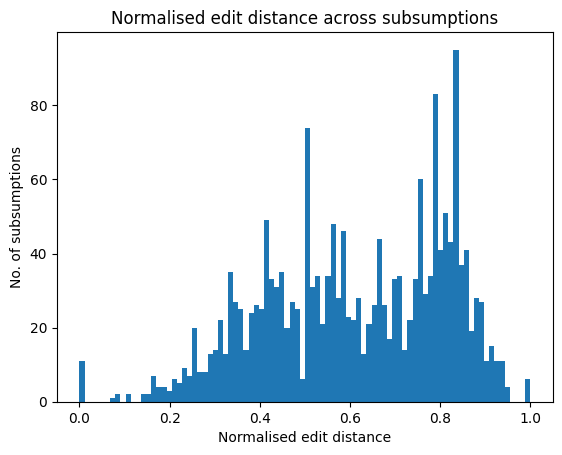

In [ ]:
plt.hist(sub_normalised, bins=len(sub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Normalised edit distance across subsumptions")
print("Normalised:", sorted(sub_norm_distribution.items(), key=lambda x:x[0]))

{'whiskers': [<matplotlib.lines.Line2D at 0x785094f83850>,
 'caps': [<matplotlib.lines.Line2D at 0x785094f834f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x785094f83820>],
 'medians': [<matplotlib.lines.Line2D at 0x785094f80550>],
 'fliers': [<matplotlib.lines.Line2D at 0x785094f804c0>],
 'means': []}

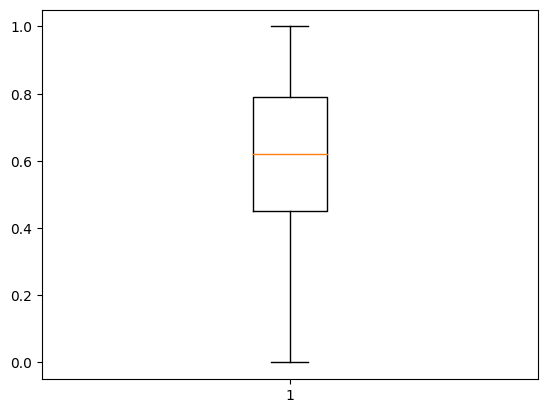

In [ ]:
plt.boxplot(sub_normalised)

In [ ]:
print("Subsumptions with distinct terms:\n")

sub_count = 0
for (source, target) in str_subsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    sub_count += 1
    if sub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{sub_count} out of {len(str_subsumptions)} ({(100 * sub_count/len(str_subsumptions)):.1f}%) are distinct")

Subsumptions with distinct terms:

botulism -> bacterial infection
hyperostosis -> non-neoplastic bone disorder
acute myeloid leukemia with t(6;9) (p23;q34.1) -> acute myeloid leukemia with recurrent genetic abnormalities
facioscapulohumeral muscular dystrophy -> muscular dystrophy
benign essential hypertension -> essential hypertension
multicentric reticulohistiocytosis -> non-neoplastic soft tissue disorder
branch retinal artery occlusion -> retinal artery occlusion
pyoureter -> abscess
cholecystitis -> non-neoplastic gallbladder disorder
granulomatous hepatitis -> hepatitis
verrucous papilloma -> epithelial neoplasm (antiquated)
skeletal muscle neoplasm -> myomatous neoplasm
cervicomedullary junction neoplasm -> spinal cord neoplasm
spindle cell synovial sarcoma -> monophasic synovial sarcoma
thyroid hyalinizing trabecular adenoma -> low risk thyroid gland neoplasm
fibrous meningioma -> grade 1 meningioma
olfactory groove meningioma -> anterior cranial fossa meningioma
pityriasis ro

In [ ]:
source_contained = np.array([1 if source in target else 0 for (source, target) in str_subsumptions.items()])
target_contained = np.array([1 if target in source else 0 for (source, target) in str_subsumptions.items()])

source_contained_distribution = Counter(source_contained)
target_contained_distribution = Counter(target_contained)

Source contained in 17 out of 1883 (0.9%)


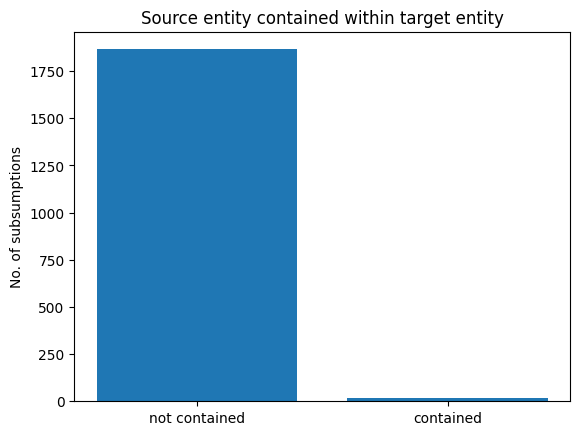

In [ ]:
plt.bar(["not contained", "contained"], [len(source_contained)-np.sum(source_contained), np.sum(source_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Source entity contained within target entity")
print(f"Source contained in {source_contained_distribution[1]} out of {len(source_contained)} ({100*source_contained_distribution[1]/len(source_contained):.1f}%)")

Target contained in 513 out of 1883 (27.2%)


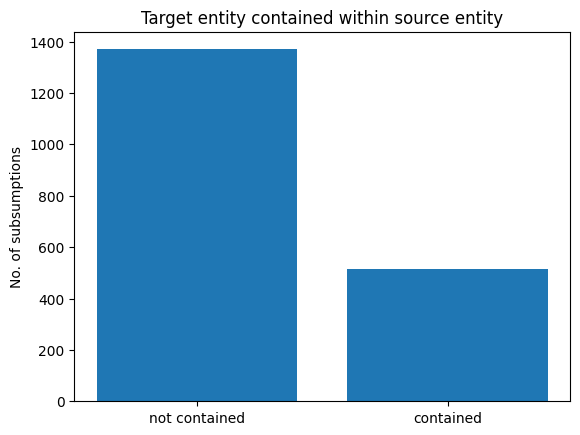

In [ ]:
plt.bar(["not contained", "contained"], [len(target_contained)-np.sum(target_contained), np.sum(target_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Target entity contained within source entity")
print(f"Target contained in {target_contained_distribution[1]} out of {len(target_contained)} ({100*target_contained_distribution[1]/len(target_contained):.1f}%)")

## Negative mappings

In [ ]:
str_nsubsumptions = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in neg_doid_to_ncit_subs.items() if source in doid.terms() and target in ncit.terms()}

nsub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_nsubsumptions.items()])
nsub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_nsubsumptions.items()])
nsub_normalised = np.round(nsub_distances / nsub_lengths, decimals=2)

nsub_dist_distribution = Counter(nsub_distances)
nsub_norm_distribution = Counter(nsub_normalised)

Distances: [(5, 2), (6, 3), (7, 3), (8, 5), (9, 6), (10, 9), (11, 22), (12, 39), (13, 43), (14, 44), (15, 71), (16, 79), (17, 90), (18, 92), (19, 94), (20, 102), (21, 97), (22, 102), (23, 87), (24, 89), (25, 91), (26, 78), (27, 60), (28, 69), (29, 52), (30, 51), (31, 44), (32, 48), (33, 39), (34, 23), (35, 39), (36, 22), (37, 31), (38, 19), (39, 15), (40, 10), (41, 10), (42, 14), (43, 13), (44, 3), (45, 11), (46, 4), (47, 7), (48, 4), (49, 3), (50, 4), (51, 3), (52, 5), (53, 6), (54, 5), (55, 3), (56, 2), (57, 1), (58, 1), (59, 3), (60, 3), (61, 1), (62, 2), (65, 1), (67, 1), (74, 1), (78, 1)]
Median: 23.0, Mean: 24.55, STD: 9.28


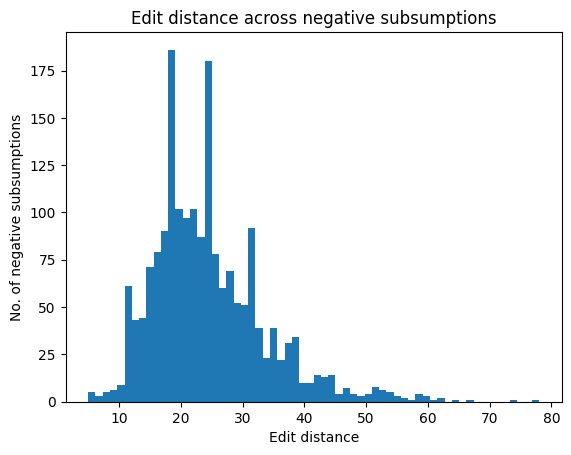

In [ ]:
plt.hist(nsub_distances, bins=len(nsub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Edit distance across negative subsumptions")
print("Distances:", sorted(nsub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_distances)}, Mean: {np.mean(nsub_distances):.2f}, STD: {np.std(nsub_distances):.2f}")

Normalised: [(0.25, 1), (0.37, 1), (0.38, 1), (0.43, 1), (0.47, 1), (0.48, 1), (0.5, 1), (0.53, 1), (0.54, 2), (0.55, 1), (0.56, 5), (0.57, 1), (0.58, 1), (0.59, 2), (0.6, 4), (0.61, 2), (0.62, 4), (0.63, 3), (0.64, 8), (0.65, 10), (0.66, 3), (0.67, 21), (0.68, 23), (0.69, 19), (0.7, 33), (0.71, 36), (0.72, 30), (0.73, 41), (0.74, 45), (0.75, 65), (0.76, 80), (0.77, 67), (0.78, 89), (0.79, 123), (0.8, 110), (0.81, 141), (0.82, 110), (0.83, 134), (0.84, 105), (0.85, 102), (0.86, 113), (0.87, 48), (0.88, 83), (0.89, 49), (0.9, 52), (0.91, 32), (0.92, 23), (0.93, 13), (0.94, 15), (0.95, 13), (0.96, 6), (0.97, 2), (1.0, 5)]
Median: 0.81, Mean: 0.81, STD: 0.07


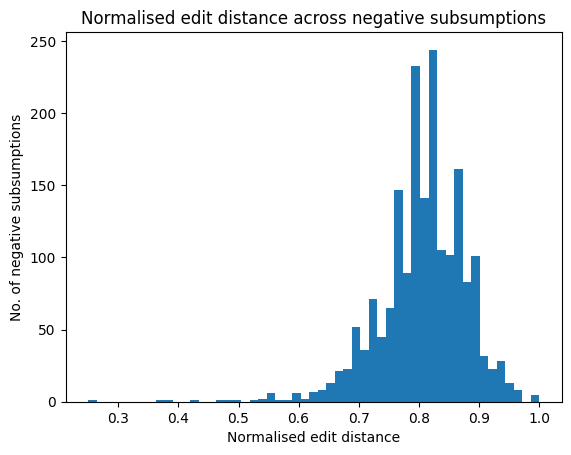

In [ ]:
plt.hist(nsub_normalised, bins=len(nsub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Normalised edit distance across negative subsumptions")
print("Normalised:", sorted(nsub_norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_normalised)}, Mean: {np.mean(nsub_normalised):.2f}, STD: {np.std(nsub_normalised):.2f}")

{'whiskers': [<matplotlib.lines.Line2D at 0x785093914e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7850939167a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7850d6c9bc40>],
 'medians': [<matplotlib.lines.Line2D at 0x785093916a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7850939158a0>],
 'means': []}

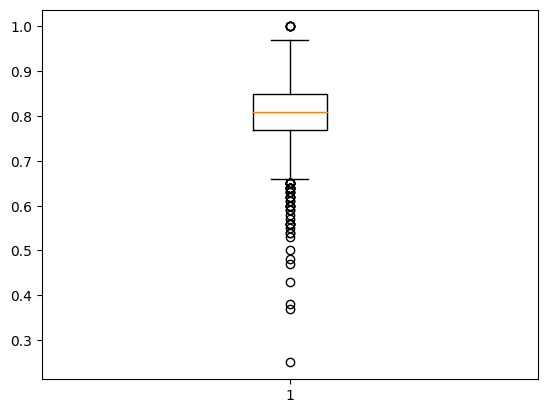

In [ ]:
plt.boxplot(nsub_normalised)

In [ ]:
print("Negative subsumptions with distinct terms:\n")

nsub_count = 0
for (source, target) in str_nsubsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    nsub_count += 1
    if nsub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{nsub_count} out of {len(str_nsubsumptions)} ({(100 * nsub_count/len(str_nsubsumptions)):.1f}%) are distinct")

Negative subsumptions with distinct terms:

paranasal sinus disease -> omphalocele
duodenitis -> skin signet ring cell basal cell carcinoma
ezb diffuse large b-cell lymphoma -> van der woude syndrome
hypertrichosis -> intrahepatic cholangiocarcinoma
edwards syndrome -> balloon cell melanoma
chronic laryngitis -> ectopic pregnancy
louse-borne relapsing fever -> cervical adenoid basal carcinoma
alcoholic neuropathy -> jackson-weiss syndrome
laryngitis -> benign ear neoplasm
syringoma -> childhood oligodendroglioma
granulomatous orchitis -> spermatic cord lipoma
multidrug-resistant tuberculosis -> paralytic ileus
venous hemangioma -> bartholin gland neoplasm
schizoaffective disorder -> atypical intradermal smooth muscle neoplasm
flying phobia -> kidney sarcoma
radiation cystitis -> cerebral malaria
varicose veins -> childhood liposarcoma
erythema infectiosum -> retroperitoneal germ cell tumor

1882 out of 1882 (100.0%) are distinct


In [ ]:
nsource_contained = np.array([1 if source in target else 0 for (source, target) in str_nsubsumptions.items()])
ntarget_contained = np.array([1 if target in source else 0 for (source, target) in str_nsubsumptions.items()])

nsource_contained_distribution = Counter(nsource_contained)
ntarget_contained_distribution = Counter(ntarget_contained)

Source contained in 0 out of 1882 (0.0%)


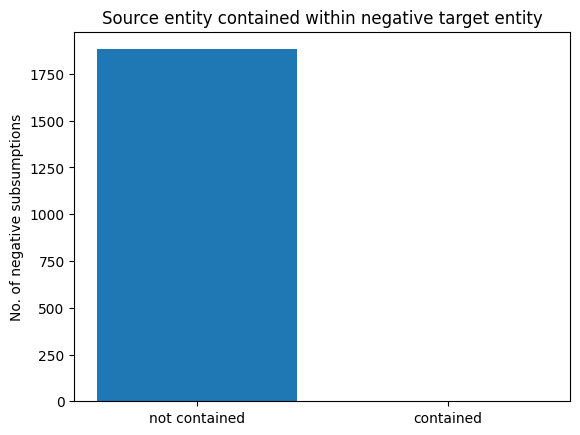

In [ ]:
plt.bar(["not contained", "contained"], [len(nsource_contained)-np.sum(nsource_contained), np.sum(nsource_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Source entity contained within negative target entity")
print(f"Source contained in {nsource_contained_distribution[1]} out of {len(nsource_contained)} ({100*nsource_contained_distribution[1]/len(nsource_contained):.1f}%)")

Target contained in 0 out of 1882 (0.0%)


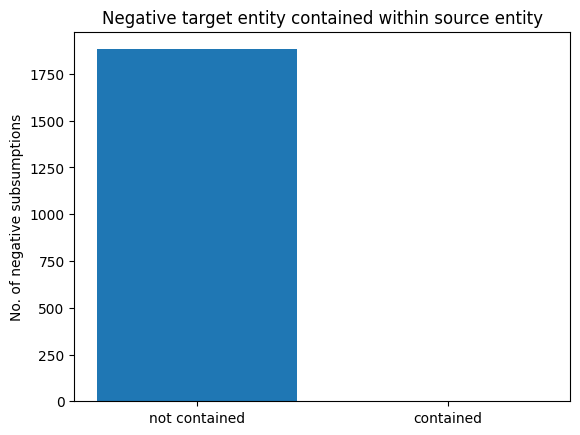

In [ ]:
plt.bar(["not contained", "contained"], [len(ntarget_contained)-np.sum(ntarget_contained), np.sum(ntarget_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Negative target entity contained within source entity")
print(f"Target contained in {ntarget_contained_distribution[1]} out of {len(ntarget_contained)} ({100*ntarget_contained_distribution[1]/len(ntarget_contained):.1f}%)")